In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Laden der Daten (angenommen bereits importiert)
df = pd.read_csv('../data/processed/interest_rates_on_new_loans_by_product/snb-data-zikreddet-de-all-20250422_0900.csv', sep=';', quotechar='"')
# Pivotieren der Daten, damit jede Kreditart eine eigene Spalte wird
df_pivot = df.pivot(index='Date', columns='D0', values='Value').reset_index()

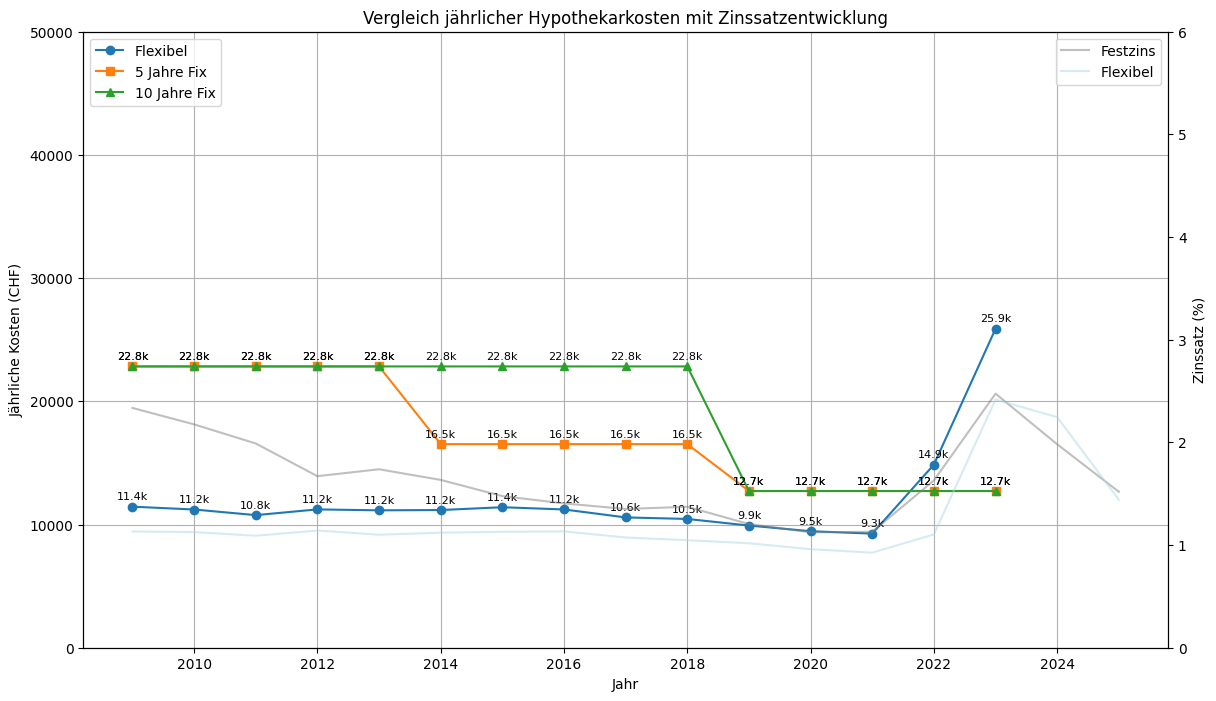

In [2]:
# Beispielwerte fuer die Berechnungen
P = 1000000  # Kreditsumme in CHF
laufzeit_jahre = 15
n = laufzeit_jahre * 12  # Monate

# Funktion zur Berechnung der jaehrlichen Zinskosten
def berechne_jaehrliche_kosten(P, zins):
    return P * zins

# Zuweisung der Zinssaetze
df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
df_pivot['Jahr'] = df_pivot['Date'].dt.year
zins_fh = df_pivot['FH'] / 100  # Festverzinsliche Hypothek
zins_mbb = df_pivot['MBB'] / 100  # Mit Basisbindung (flexibel)

# Vorbereitung der Szenarien
jahre = np.arange(2009, 2009 + laufzeit_jahre)
kosten_flex = []
kosten_fix5 = []
kosten_fix10 = []

# Zinssaetze zu Beginn und bei Neuverhandlungen
zins_fix5_start = zins_fh.iloc[0]
zins_fix5_neu1 = zins_fh.iloc[60] if len(zins_fh) > 60 else zins_fh.iloc[-1]
zins_fix5_neu2 = zins_fh.iloc[120] if len(zins_fh) > 120 else zins_fh.iloc[-1]
zins_fix10_start = zins_fh.iloc[0]
zins_fix10_neu = zins_fh.iloc[120] if len(zins_fh) > 120 else zins_fh.iloc[-1]

# Flexibel: jaehrliche Zinskosten anhand monatlich veraenderter Zinssaetze
for jahr in range(laufzeit_jahre):
    start_idx = jahr * 12
    end_idx = start_idx + 12
    jahr_zinsen = []
    for idx in range(start_idx, min(end_idx, len(zins_mbb))):
        jahr_zinsen.append(berechne_jaehrliche_kosten(P, zins_mbb.iloc[idx]))
    kosten_flex.append(np.mean(jahr_zinsen))

# Fix 5 Jahre: Zins bleibt 5 Jahre gleich
for jahr in range(laufzeit_jahre):
    if jahr < 5:
        zins = zins_fix5_start
    elif jahr < 10:
        zins = zins_fix5_neu1
    else:
        zins = zins_fix5_neu2
    kosten_fix5.append(berechne_jaehrliche_kosten(P, zins))

# Fix 10 Jahre: Zins bleibt 10 Jahre gleich
for jahr in range(laufzeit_jahre):
    if jahr < 10:
        zins = zins_fix10_start
    else:
        zins = zins_fix10_neu
    kosten_fix10.append(berechne_jaehrliche_kosten(P, zins))

# Jahresdurchschnitt der Zinssaetze
zins_fh_jahr = df_pivot.groupby('Jahr')['FH'].mean() / 100
zins_mbb_jahr = df_pivot.groupby('Jahr')['MBB'].mean() / 100

# Plot: Kostenvergleich mit zweiter Achse fuer Zinssaetze
fig, ax1 = plt.subplots(figsize=(14,8))

# Primäre Achse - jährliche Kosten
ax1.plot(jahre, kosten_flex, label='Flexibel', marker='o')
ax1.plot(jahre, kosten_fix5, label='5 Jahre Fix', marker='s')
ax1.plot(jahre, kosten_fix10, label='10 Jahre Fix', marker='^')
ax1.set_xlabel('Jahr')
ax1.set_ylabel('Jährliche Kosten (CHF)')
ax1.set_ylim(0, 50000)
ax1.grid()
ax1.legend(loc='upper left')

# Werte als Text bei den Punkten
for i in range(len(jahre)):
    ax1.annotate(f"{kosten_flex[i]/1000:.1f}k", (jahre[i], kosten_flex[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax1.annotate(f"{kosten_fix5[i]/1000:.1f}k", (jahre[i], kosten_fix5[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax1.annotate(f"{kosten_fix10[i]/1000:.1f}k", (jahre[i], kosten_fix10[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

# Sekundäre Achse - Zinssaetze (auf gleiche Jahre gemappt)
ax2 = ax1.twinx()
ax2.plot(zins_fh_jahr.index, zins_fh_jahr * 100, color='grey', alpha=0.5, label='Festzins')
ax2.plot(zins_mbb_jahr.index, zins_mbb_jahr * 100, color='lightblue', alpha=0.5, label='Flexibel')
ax2.set_ylabel('Zinssatz (%)')
ax2.set_ylim(0, 6)
ax2.legend(loc='upper right')

plt.title('Vergleich jährlicher Hypothekarkosten mit Zinssatzentwicklung')
plt.show()

Tilgung je Jahr nach Hypothekenmodell:
 Jahr  Tilgung Flexibel (CHF)  Tilgung 5 Jahre Fix (CHF)  Tilgung 10 Jahre Fix (CHF)
 2010                 15000.0                        0.0                         0.0
 2011                 15000.0                        0.0                         0.0
 2012                 15000.0                        0.0                         0.0
 2013                 15000.0                        0.0                         0.0
 2014                 15000.0                    50000.0                         0.0
 2015                 15000.0                        0.0                         0.0
 2016                 15000.0                        0.0                         0.0
 2017                 15000.0                        0.0                         0.0
 2018                 15000.0                        0.0                         0.0
 2019                 15000.0                    50000.0                    100000.0
 2020                 1500

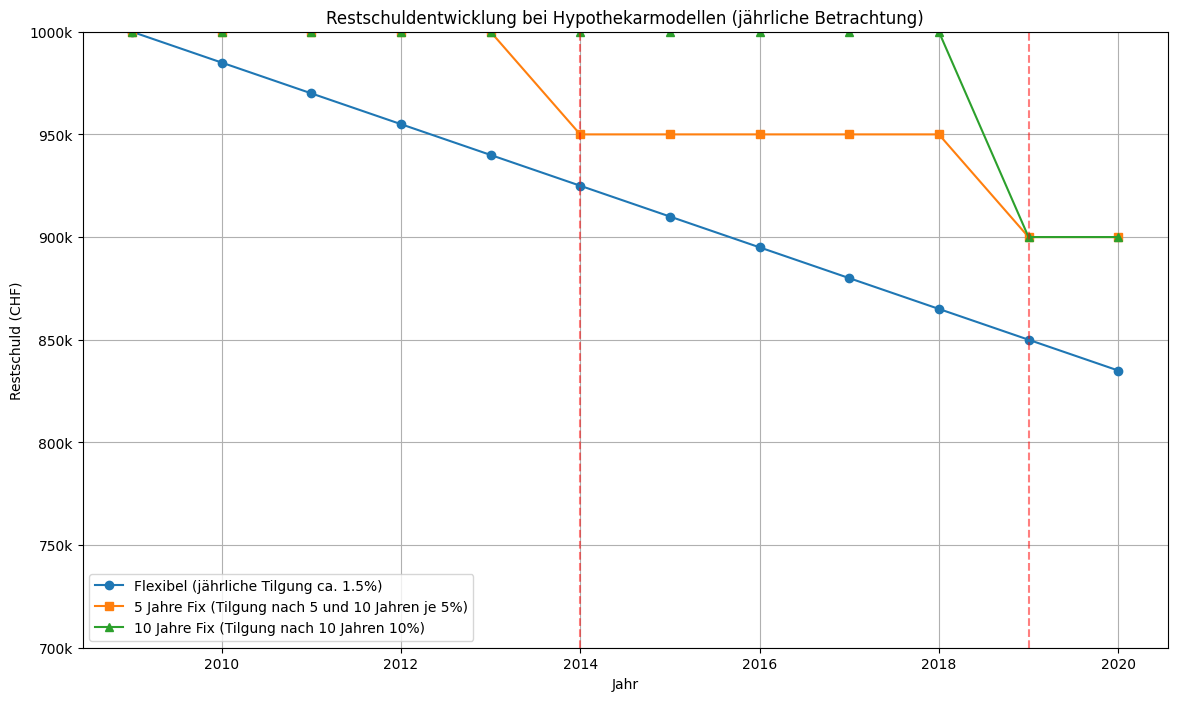

In [3]:
# Annahmen
P = 1000000  # Kreditsumme in CHF
laufzeit_jahre = 11  # angepasst auf 11 Jahre
n = laufzeit_jahre * 12  # Monate

# Funktion zur Berechnung der monatlichen Rate (nur Zinszahlung)
def berechne_zinszahlung(P, r):
    return P * r

# Tilgungsverlauf neu aufgebaut
saldo_flex = [P]
saldo_fix5 = [P]
saldo_fix10 = [P]

# Flexibel: Zinszahlungen plus ca. 1.5% p.a. Tilgung
saldo = P
for idx in range(n):
    r = zins_mbb.iloc[min(idx, len(zins_mbb)-1)] / 12
    tilgung_monatlich = (P * 0.015) / 12  # 1.5% p.a.
    saldo -= tilgung_monatlich
    saldo_flex.append(max(saldo, 0))

# 5 Jahre Fix: Tilgung nur in Jahr 5 (Monat 59) und Jahr 10 (Monat 119) (5% jeweils)
saldo = P
zins_fix5_1 = zins_fh.iloc[0] / 12
zins_fix5_2 = zins_fh.iloc[60] / 12 if len(zins_fh) > 60 else zins_fh.iloc[-1] / 12
for idx in range(n):
    if idx == 59:
        saldo -= P * 0.05  # Tilgung 5% nach 5 Jahren
    if idx == 119:
        saldo -= P * 0.05  # Tilgung 5% nach weiteren 5 Jahren
    saldo_fix5.append(max(saldo, 0))

# 10 Jahre Fix: Tilgung nur in Jahr 10 (Monat 119) (10%)
saldo = P
zins_fix10 = zins_fh.iloc[0] / 12
for idx in range(n):
    if idx == 119:
        saldo -= P * 0.10  # Tilgung 10% nach 10 Jahren
    saldo_fix10.append(max(saldo, 0))

# Umrechnung auf jaehrliche Werte fuer Tilgung
jahre = np.arange(0, 12, 1)
saldo_flex_jahr = [saldo_flex[min(i*12, len(saldo_flex)-1)] for i in jahre]
saldo_fix5_jahr = [saldo_fix5[min(i*12, len(saldo_fix5)-1)] for i in jahre]
saldo_fix10_jahr = [saldo_fix10[min(i*12, len(saldo_fix10)-1)] for i in jahre]

# Berechnung der jaehrlichen Tilgungsbetraege
tilgung_flex = [saldo_flex_jahr[i-1] - saldo_flex_jahr[i] for i in range(1, len(saldo_flex_jahr))]
tilgung_fix5 = [saldo_fix5_jahr[i-1] - saldo_fix5_jahr[i] for i in range(1, len(saldo_fix5_jahr))]
tilgung_fix10 = [saldo_fix10_jahr[i-1] - saldo_fix10_jahr[i] for i in range(1, len(saldo_fix10_jahr))]

# Tabelle der Tilgungsbetraege erstellen
tilgung_df = pd.DataFrame({
    'Jahr': jahre[1:] + 2009,
    'Tilgung Flexibel (CHF)': tilgung_flex,
    'Tilgung 5 Jahre Fix (CHF)': tilgung_fix5,
    'Tilgung 10 Jahre Fix (CHF)': tilgung_fix10
})

# Ausgabe der Tilgungstabelle
print("Tilgung je Jahr nach Hypothekenmodell:")
print(tilgung_df.to_string(index=False))

# Erklaerungstext
print("\nErklärung: Die jährlichen Tilgungsbeträge wurden angepasst. Bei flexiblen Hypotheken wird etwa 1.5% p.a. getilgt, bei Fixhypotheken erfolgen Tilgungen von 5% nach 5 und 10 Jahren (bei 5-Jahresmodell) bzw. 10% nach 10 Jahren (bei 10-Jahresmodell).")

# Plot Tilgungsverlauf ueber 11 Jahre (jaehrlich)
plt.figure(figsize=(14,8))
plt.plot(jahre + 2009, saldo_flex_jahr, marker='o', label='Flexibel (jährliche Tilgung ca. 1.5%)')
plt.plot(jahre + 2009, saldo_fix5_jahr, marker='s', label='5 Jahre Fix (Tilgung nach 5 und 10 Jahren je 5%)')
plt.plot(jahre + 2009, saldo_fix10_jahr, marker='^', label='10 Jahre Fix (Tilgung nach 10 Jahren 10%)')

# Highlight der Tilgungsjahre
highlight_years = [2014, 2019]
for year in highlight_years:
    plt.axvline(x=year, color='red', linestyle='--', alpha=0.5)

plt.xlabel('Jahr')
plt.ylabel('Restschuld (CHF)')
plt.title('Restschuldentwicklung bei Hypothekarmodellen (jährliche Betrachtung)')
plt.yticks(np.arange(700000, 1100000, 50000), labels=[f"{int(x/1000)}k" for x in np.arange(700000, 1100000, 50000)])
plt.grid()
plt.legend()
plt.ylim(700000, 1000000)
plt.show()

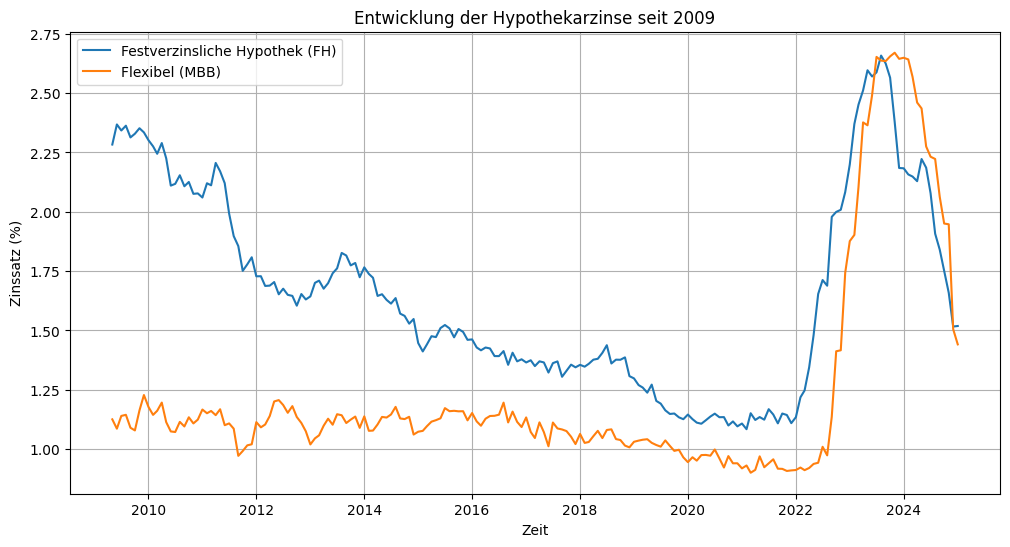

In [4]:
# Entwicklung der Zinssaetze ueber die Monate
plt.figure(figsize=(12,6))
plt.plot(df_pivot['Date'], zins_fh * 100, label='Festverzinsliche Hypothek (FH)')
plt.plot(df_pivot['Date'], zins_mbb * 100, label='Flexibel (MBB)')
plt.xlabel('Zeit')
plt.ylabel('Zinssatz (%)')
plt.title('Entwicklung der Hypothekarzinse seit 2009')
plt.legend()
plt.grid()
plt.show()